In [8]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [25]:
class node(object):
 
    def __init__(self, weights_lenght, x, y, index):
        # the dimention of the weight vector
        self.weights_lenght = weights_lenght; 
        # initializes weights to random values 
        self.weights = np.random.rand(1, weights_lenght)[0];
        # saves the x, y coordinates of the node in the rectangular grid
        self.x_coord = x;
        self.y_coord = y;
        self.index = index;
   
    def weight_distance(self, node_weights):
        # calculates the distance between the data point and the weight vector
        #print(self.weights,node_weights)
        distance_array = self.weights - node_weights;
        distance_array = distance_array*distance_array; 
        distance = np.sum(distance_array)
        return math.sqrt(distance);
 
    def distance(self, x, y):
        # calculates the distance between the nodes in the rectangular grid 
        distance = (self.x_coord - x)*(self.x_coord - x)+(self.y_coord - y)*(self.y_coord - y);
        return math.sqrt(distance);
    
    def adjust_weights(self, data_row, learning_rate, influence):
        # Adjusts the weight of the node to better match the data
        self.weights = self.weights + learning_rate * influence * (data_row - self.weights);
        #self.weights = normalize(self.weights.reshape(1, -1))[0];
        
    def get_weights(self):
        # return the weight vector
        return self.weights;
    
    def get_x(self):
        # returns the x coordinate of the position grid
        return self.x_coord;
    
    def get_y(self):
        # returns the y coordinate of the position grid
        return self.y_coord;
    
    def get_index(self):
        # returns the y coordinate of the position grid
        return self.index;
    

In [111]:
class SOM(object):

    def __init__(self, data, data_row_size, size_row, size_col):
        # initializes fields 
        self.SOM_grid = [];
        self.SOM_grid_pos = [];
        self.size_row = size_row;
        self.size_col = size_col;
        self.data = data;
        count = 0
        # initializes the SOM gird with node objects
        for i in range(0, size_col):
            for j in range(0, size_row): 
                self.SOM_grid.append(node(data_row_size, i, j, count));
                count += count;
      
    def learn(self, data, num_iterations, start_learning_rate):
        # calculates the initial radius for neighborhood
        map_radius = max(self.size_row, self.size_col)/2;
        # calculates the time constant 
        time_constant = num_iterations/float(math.log(map_radius));
        
        # sets the initial learning rate and the data field
        learning_rate = start_learning_rate; 
        self.data = data;
        
        count = num_iterations;
        iteration_count = 0;
        
        # iterate over the data 
        while num_iterations > iteration_count: 
           
            # count the number of iterations
            iteration_count= iteration_count + 1;
            
            # pick a random index and read the data at that index
            rand_point = np.random.randint(0, data[:,0].size); 
            data_row = data[rand_point];
            # remove the read datapoint from the dataset
            #data = np.delete(data, (rand_point), axis=0)
            
            # find the winning node
            winning_node = self.best_matching_node(data_row);
            
            # calculate the neighborhood radius
            neighbourhood_radius = map_radius * math.exp(-iteration_count/time_constant);

            # find all the neighboors and adjust their weights 
            for i in range(0, len(self.SOM_grid)):

                curr_dist_to_bmu = self.SOM_grid[i].distance(winning_node.get_x(), winning_node.get_y());
                curr_dist_to_bmu_sqrt = curr_dist_to_bmu*curr_dist_to_bmu;
                neighbourhood_radius_sqrt = neighbourhood_radius*neighbourhood_radius;
                
                if curr_dist_to_bmu_sqrt < neighbourhood_radius_sqrt:
                    # calculate the influence of the new data point on the node
                    influence = math.exp(-(curr_dist_to_bmu_sqrt) / (2*neighbourhood_radius_sqrt));
                    # adjust the weight based on influence, learning rate and the weights of data
                    self.SOM_grid[i].adjust_weights(data_row, learning_rate, influence);
                    
            # reduce the learning rate on each iteration
            learning_rate = start_learning_rate * math.exp(-iteration_count/num_iterations);
            #count = count - 1;
  
    def best_matching_node(self, data_row):
        # initialize the min distance to the biggest number possible
        min_distance = float('inf');
        distance = 0;
        # assigne a winning node to be the first node in the map
        winning_node = self.SOM_grid[0];
        # iterate over all the nodes in the map
        for i in range(0, len(self.SOM_grid)):
            # calculate the distance between the data row and the node
            distance = self.SOM_grid[i].weight_distance(data_row);
            # if we found a smaller distance, update the winning node and the min_distance
            if min_distance > distance:
                winning_node = self.SOM_grid[i];
                min_distance = distance;
        # return the node with the smallest distance from the data point
        return winning_node;
    
    def predict(self, data):
        classes = self.best_matching_node(data).get_index();
        return classes
        
    def get_weights(self):
        # array to store the coordinates of all the nodes
        coord_array = []
        for i in range(0, len(self.SOM_grid)): 
                # appends the coordniated of the nodes to the array
                #coord_array.append([self.SOM_grid[i].get_weights()[0], self.SOM_grid[i].get_weights()[1]]);
                coord_array.append(np.array(self.SOM_grid[i].get_weights()));
        return coord_array;

    def plot(self):
        # plot the dataset 
        plt.plot(self.data[:, 0], self.data[:, 1], 'co')
        # plot the weights of SOM
        for i in range(0, len(self.SOM_grid)):
            plt.plot(self.SOM_grid[i].get_weights()[0], self.SOM_grid[i].get_weights()[1], 'k^')
        
        plt.title("Original data(Cyan) and estimated weights(Black)")
        plt.xlabel("Weight 1")
        plt.ylabel("Weight 2")
        plt.show()
                     
    def show_grid(self):
        # array to store the coordinates of all the nodes
        coord_array = []
        for i in range(0, len(self.SOM_grid)): 
                # appends the coordniated of the nodes to the array
                coord_array.append([self.SOM_grid[i].get_weights()[0], self.SOM_grid[i].get_weights()[1]]);

        # loops over the array of coordinates and draws the vertical grid lines
        for j in range(0, self.size_row):
            for i in range(0, self.size_row-1):
                if i+self.size_row*j+1<len(coord_array):
                    plt.plot([coord_array[i+self.size_row*j][0],coord_array[i+self.size_row*j+1][0]], [coord_array[i+self.size_row*j][1],coord_array[i+self.size_row*j+1][1]], marker = 'o', color='black')
        
        # loops over the array of coordinates and draws the horizontal grid lines
        for j in range(0, self.size_row):
            for i in range(0, self.size_row):
                if (i+self.size_row*j+self.size_row)<len(coord_array):
                    plt.plot([coord_array[i+self.size_row*j][0],coord_array[i+self.size_row*j+self.size_row][0]], [coord_array[i+self.size_row*j][1],coord_array[i+self.size_row*j+self.size_row][1]], marker = 'o', color='black')
        
        plt.title("Map connecting weights")
        plt.xlabel("Weight 1 of SOM node")
        plt.ylabel("Weight 2 of SOM node")

        plt.show()
    
                    

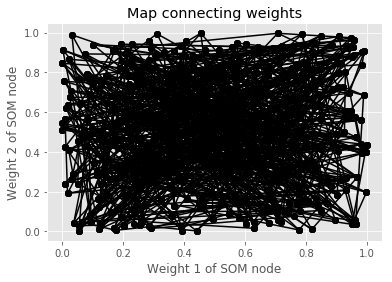

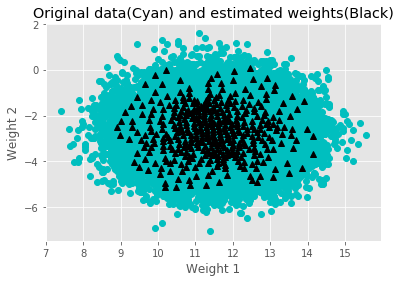

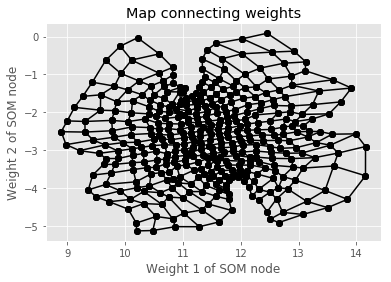

In [50]:
# 2D Gaussian
X, y = make_blobs(n_samples=50000, n_features=2, centers=1, cluster_std=1.0, center_box=(-20.0, 20.0))
X = np.array(X)

test_som = SOM(X, 2, 20, 20);
test_som.show_grid();
test_som.learn(X, 50000, 0.5);
test_som.plot();
test_som.show_grid();

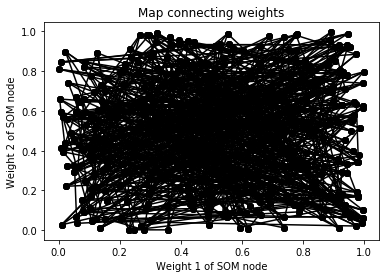

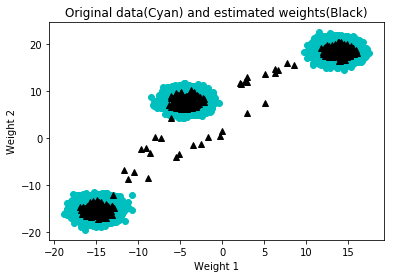

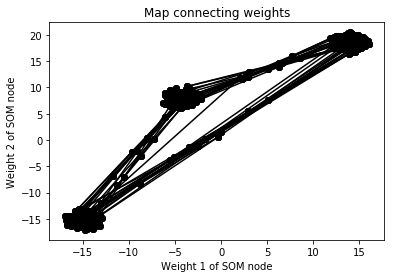

In [120]:
# 3D Gaussian, 3 clusters
X, y = make_blobs(n_samples=50000, n_features=3, centers=3, cluster_std=1.0, center_box=(-20.0, 20.0))
X = np.array(X)

test_som = SOM(X, 3, 20, 20);
test_som.show_grid();
test_som.learn(X, 50000, 0.5);
test_som.plot();
test_som.show_grid();

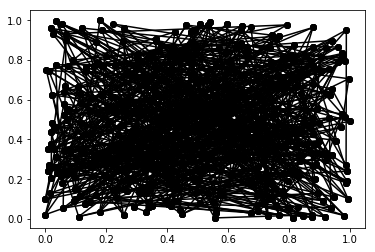

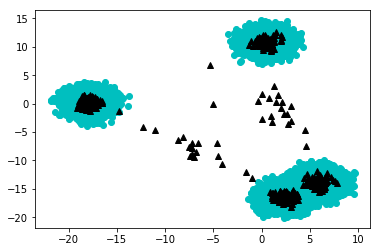

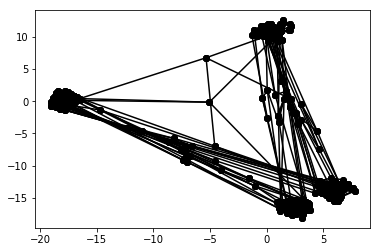

In [109]:
# 8D Gaussian, 4 clusters
X, y = make_blobs(n_samples=50000, n_features=8, centers=4, cluster_std=1.0, center_box=(-20.0, 20.0))
X = np.array(X)

test_som = SOM(X, 8, 20, 20);
test_som.show_grid();
test_som.learn(X, 50000, 0.5);
test_som.plot();
test_som.show_grid();

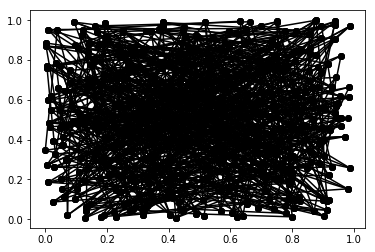

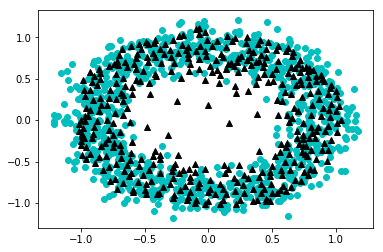

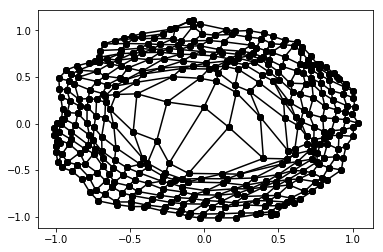

In [108]:
from sklearn.datasets import make_circles 

# 2D circles
X = make_circles(n_samples=1000, shuffle=True, noise=0.1, random_state=None, factor=0.8)
X = np.array(X[0])

test_som = SOM(X, 2, 20, 20);
test_som.show_grid();
test_som.learn(X, 1000, 0.5);
test_som.plot();
test_som.show_grid();

In [ ]:
# 8D Gaussian, 4 clusters
X, y = make_blobs(n_samples=100, n_features=8, centers=4, cluster_std=1.0, center_box=(-20.0, 20.0))
X = np.array(X)

test_som = SOM(X, 8, 20, 20);
test_som.show_grid();
test_som.learn(X, 100, 0.5);
test_som.plot();
test_som.show_grid();

[ 0  0  0  4 15 12  0  0  0  0  3 16 15 14  0  0  0  0  8 13  8 16  0  0  0
  0  1  6 15 11  0  0  0  1  8 13 15  1  0  0  0  9 16 16  5  0  0  0  0  3
 13 16 16 11  5  0  0  0  0  3 11 16  9  0]
(177, 64)


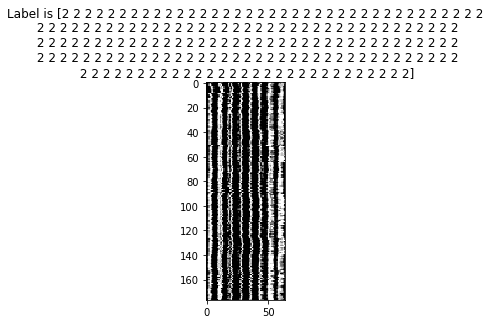

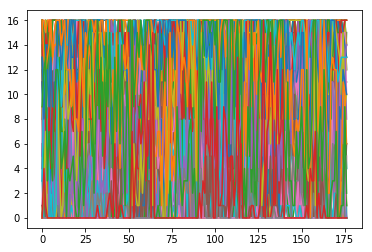

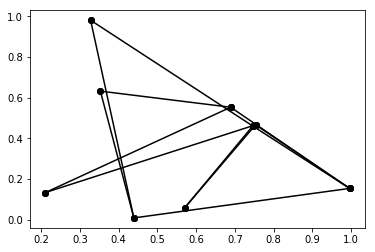

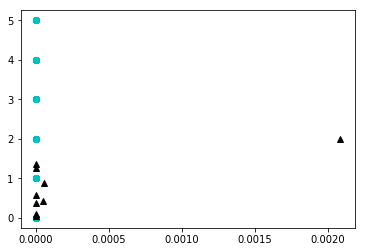

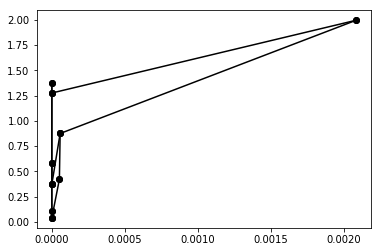

In [99]:
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=3)

X = digits.data
Y = digits.target
filter_for_two = np.where(Y == 2)
X = digits.data[filter_for_two]
Y = digits.target[filter_for_two]


        # The rest of columns are pixels

        # Make those columns into a array of 8-bits pixels
        # This array will be of 1D with length 784
        # The pixel intensity values are integers from 0 to 255
pixels = np.array(X, dtype='uint8')

        # Reshape the array into 28 x 28 array (2-dimensional array)
#pixels = X.reshape((28, 28))


plt.title('Label is {label}'.format(label=Y))
print(pixels[0])
print(X.shape)
plt.imshow(pixels, cmap='gray')
plt.show()

plt.plot(X)
#import matplotlib.pyplot as plt 
#plt.gray() 
#plt.matshow(digits.images[4]) 
plt.show() 
        
    
test_som = SOM(X, 64, 3, 3);
test_som.show_grid();
test_som.learn(X, 100, 0.5);
test_som.plot();
test_som.show_grid();

In [51]:
images = pd.read_csv('hmnist_64_64_L.csv')

# small sample of class 1 and class 2
#images_no_lab = images[500:750,0:4096]
#print(images[500:750,4096]) #labels
#plt.imshow(images[0].reshape((64,64)))

In [67]:
images = np.array(images)
print(images.shape)

(5000, 4097)


Automatically created module for IPython interactive environment
(537, 64)
Computing random projection
Computing PCA projection
[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   1.  10. ...,  10.   9.   0.]
 [  0.   0.  15. ...,   6.   2.   0.]
 [  0.   0.   6. ...,   6.   0.   0.]]


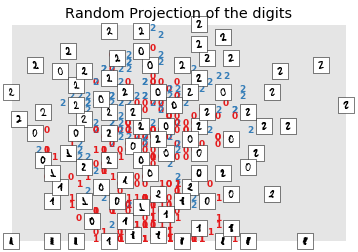

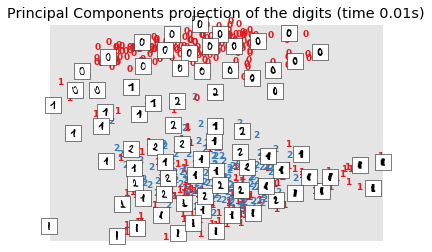

In [66]:
print(__doc__)
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=3)
X = digits.data
print(X.shape)
y = digits.target
filter_for_two = np.where(y == 2)
#X = digits.data[filter_for_two]
#Y = digits.target[filter_for_two]
n_samples, n_features = X.shape
n_neighbors = 20


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)





#----------------------------------------------------------------------
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")


#----------------------------------------------------------------------
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
print(X)
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))
plt.show()

#print(X_pca)

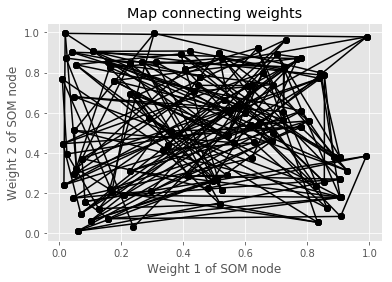

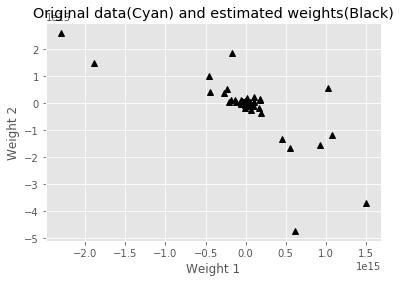

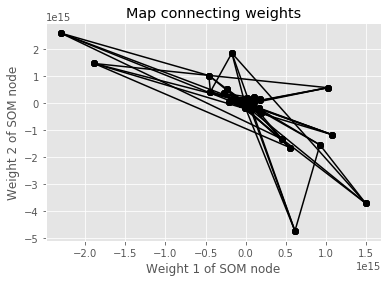

(537, 64)
Computing PCA projection


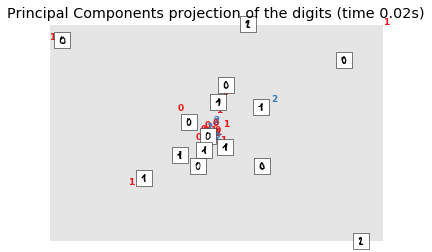

In [67]:
test_som = SOM(X, 64, 10, 10);
test_som.show_grid();
test_som.learn(X, 360, 5);
test_som.plot();
test_som.show_grid();
som = test_som.get_weights();
print(X.shape)
print("Computing PCA projection")
t0 = time()
som_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(som)
plot_embedding(som_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))
plt.show()



In [68]:
print(X[0,:], y)
print(test_som.predict(X[0,:]))

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.] [0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2 0 0 1 2 1 1 1 1 0 1 2 2
 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2 0 0 1 2 1 1 1 1 0 1
 2 2 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2 0 0 1 2 1 1 1 1
 0 1 2 2 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2 0 0 1 2 1 1
 1 1 0 1 2 2 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2 0 0 1 2
 1 1 1 1 0 1 2 2 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2 0 0
 1 2 1 1 1 1 0 1 2 2 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 2 2 0 1 2 1 0 2 2
 0 0 1 2 1 1 1 1 0 1 2 2 2 0 1 2 0 1 2 0 1 2 0 0 1 1 2 2 0 1 2 1 0 2 2 0 0
 1 2 1 1 1 1 0 1 2 2 2 0 0 1 2 0 1 2 0 1 2 0 0 1 1 0 0 2 0 1 2 1 0 2 2 0 0

IndexError: too many indices for array

(150, 2)


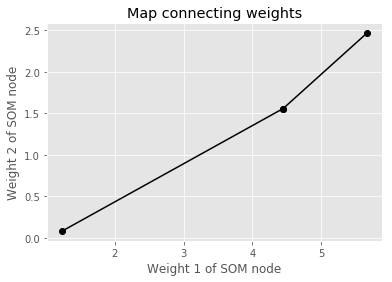

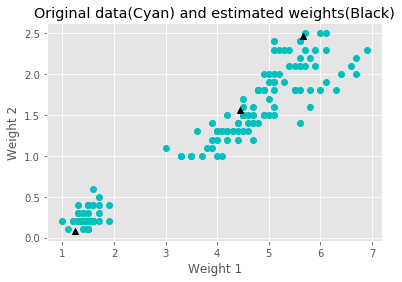

[[ 1.23581795  0.0822866 ]
 [ 4.45033803  1.55656946]
 [ 5.66776049  2.46340252]]
[ 1.23581795  4.45033803  5.66776049]
[ 0.0822866   1.55656946  2.46340252]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


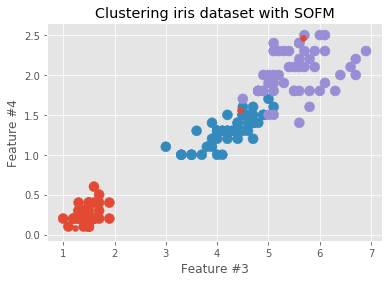

0


In [121]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt


plt.style.use('ggplot')



if __name__ == '__main__':
    ggplot_colors = plt.rcParams['axes.prop_cycle']
    colors = np.array([c['color'] for c in ggplot_colors])

    dataset = datasets.load_iris()
    
    
    # use only two features in order
    # to make visualization simpler
    data = dataset.data[:, [2, 3]]
    mask = np.array([True, True, False, False])
    index = np.array([0, 1])
    data = data[:, index]
    #print(type(data))
    print(data.shape)
    target = dataset.target

    sofm = SOM(data, 2, 3, 1);
    sofm.learn(data, 1000, );
    sofm.show_grid();
    sofm.plot();

    plt.title('Clustering iris dataset with SOFM')
    plt.xlabel('Feature #3')
    plt.ylabel('Feature #4')
    #print(sofm.get_weights())
    print(np.array(sofm.get_weights()))
    print(np.array(sofm.get_weights())[:,0])
    print(np.array(sofm.get_weights())[:,1])
    print(target)
    plt.scatter(*data.T, c=colors[target], s=100, alpha=1)
    cluster_centers = plt.scatter(np.array(sofm.get_weights())[:,0], np.array(sofm.get_weights())[:,1])

    #plt.legend([cluster_centers], ['Cluster center'], loc='upper left')
    plt.show()
    print(sofm.predict([ 5.78959616,  2.01448819]))

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets



GRID_HEIGHT = 40
GRID_WIDTH = 40

digits = datasets.load_digits()
data = digits.data

sofm = SOM(data, 64, 3, 3);
sofm.learn(data, 100, 0.5);

clusters = sofm.predict(data)
print(clusters)
print("Building visualization...")
plt.figure(figsize=(12, 11))

grid = gridspec.GridSpec(GRID_HEIGHT, GRID_WIDTH)
grid.update(wspace=0, hspace=0)

for row_id in range(data[:,0].size):
    #print("Progress: {:.2%}".format(row_id / GRID_HEIGHT))

    #for col_id in range(GRID_WIDTH):
        #index = row_id * GRID_HEIGHT + col_id
    clustered_samples = data[clusters == index]

    if len(clustered_samples) > 0:
            # We take the first sample, but it can be any
            # sample from this cluster
        sample = clustered_samples[0]

    else:
            # If we don't have samples in cluster then
            # it means that there is a gap in space
        sample = np.zeros(64)
    #print(sample)
    plt.subplot(grid[index])
    plt.imshow(sample.reshape((8, 8)), cmap='Greys')
    plt.axis('off')

print("Visualization has been built succesfully")
plt.show()

0
Building visualization...


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1797 but corresponding boolean dimension is 2

In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from neupy import algorithms, environment


environment.reproducible()

GRID_HEIGHT = 40
GRID_WIDTH = 40

digits = datasets.load_digits()
data = digits.data

sofm = algorithms.SOFM(
    n_inputs=64,
    features_grid=(GRID_HEIGHT, GRID_WIDTH),

    # Learning radius defines area within which we find
    # winning neuron neighbours. The higher the value
    # the more values we will be updated after each iteration.
    learning_radius=5,
    # Every 20 epochs learning radius will be reduced by 1.
    reduce_radius_after=20,

    step=0.5,
    std=1,

    shuffle_data=True,
    verbose=True,
)

sofm.train(data, epochs=100)
clusters = sofm.predict(data).argmax(axis=1)

print("Building visualization...")
plt.figure(figsize=(12, 11))

grid = gridspec.GridSpec(GRID_HEIGHT, GRID_WIDTH)
grid.update(wspace=0, hspace=0)

for row_id in range(GRID_HEIGHT):
    print("Progress: {:.2%}".format(row_id / GRID_HEIGHT))

    for col_id in range(GRID_WIDTH):
        index = row_id * GRID_HEIGHT + col_id
        clustered_samples = data[clusters == index]

        if len(clustered_samples) > 0:
            # We take the first sample, but it can be any
            # sample from this cluster
            sample = clustered_samples[0]

        else:
            # If we don't have samples in cluster then
            # it means that there is a gap in space
            sample = np.zeros(64)

        plt.subplot(grid[index])
        plt.imshow(sample.reshape((8, 8)), cmap='Greys')
        plt.axis('off')

print("Visualization has been built succesfully")
plt.show()

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.umath failed to import

ImportError: numpy.core.umath failed to import